Read data and Exploratory Data Aalysis

In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url='/content/drive/MyDrive/dataset/amazon_electronic_subset.csv'

In [4]:
!pip install pyspark==2.3.0

     |████████████████████████████████| 211.9 MB 57 kB/s 
     |████████████████████████████████| 189 kB 20.2 MB/s 
  Created wheel for pyspark: filename=pyspark-2.3.0-py2.py3-none-any.whl size=212271917 sha256=f974c6037f3e096e101c1c839cd18d8a9624ec76abdb6c59064de7fd3de268ec
  Stored in directory: /root/.cache/pip/wheels/c0/ed/08/40a6e0c03e6564ebe4e757a6081779570dd81f73a5817789e6
Successfully built pyspark


In [5]:
#import module
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import gzip

In [14]:
#import module
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
from copy import deepcopy
import time
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error

In [7]:
#create session
appName = "Recommendation system in Spark with ALS"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [8]:
df1 = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df1.head(3)

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1425280,2.0,NaN,True,"01 24, 2015",AMFPAS8VMIDGJ,B002B3YCQM,{'Package Type:': ' Standard Packaging'},Crewtx,I've stopped counting the number of mice I've ...,I've stopped counting the number of mice I've ...,1422057600,NaN
1,4253927,4.0,2,True,"12 3, 2017",ABID49T47BLBF,B00JXXXOS0,NaN,Donald L. DeMent,I've only had it 1 day but it worked for me pl...,Worked for playing local (R 1) DVDs and the Au...,1512259200,NaN
2,3395176,5.0,NaN,True,"09 24, 2014",A2IQGDEA5FONCT,B00CSQYVWM,{'Style:': ' Skeleton Housing'},JT,perfect for indoors and automobile use.,Five Stars,1411516800,NaN


In [9]:
from copy import deepcopy

In [10]:
dataset=deepcopy(df1)
dataset.drop(['image','style','vote','reviewText','reviewerName','verified','summary'],axis=1, inplace = True)
dataset.fillna(value = 0, inplace = True)
dataset.drop_duplicates

<bound method DataFrame.drop_duplicates of         Unnamed: 0  overall  ...        asin unixReviewTime
0          1425280      2.0  ...  B002B3YCQM     1422057600
1          4253927      4.0  ...  B00JXXXOS0     1512259200
2          3395176      5.0  ...  B00CSQYVWM     1411516800
3          1421371      4.0  ...  B002AF5184     1354665600
4          2768360      5.0  ...  B008LTBM6S     1451952000
...            ...      ...  ...         ...            ...
235881     2741767      5.0  ...  B008DBI5RI     1360108800
235882     3967102      5.0  ...  B00HNDCWQM     1464998400
235883     1020058      5.0  ...  B0014KQ4NM     1425513600
235884     3661069      3.0  ...  B00EPCNB96     1446336000
235885      363914      5.0  ...  B0009N8SMK     1473984000

[235886 rows x 6 columns]>

In [11]:
rev1=deepcopy(dataset)

In [12]:
#count of Ratings
rating_cnt = pd.DataFrame(rev1['overall'].value_counts()).reset_index()
rating_cnt.columns = ['Labels', 'Ratings']
rating_cnt

,Labels,Ratings
0,5.0,151326
1,4.0,39809
2,3.0,17667
3,1.0,16350
4,2.0,10734


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


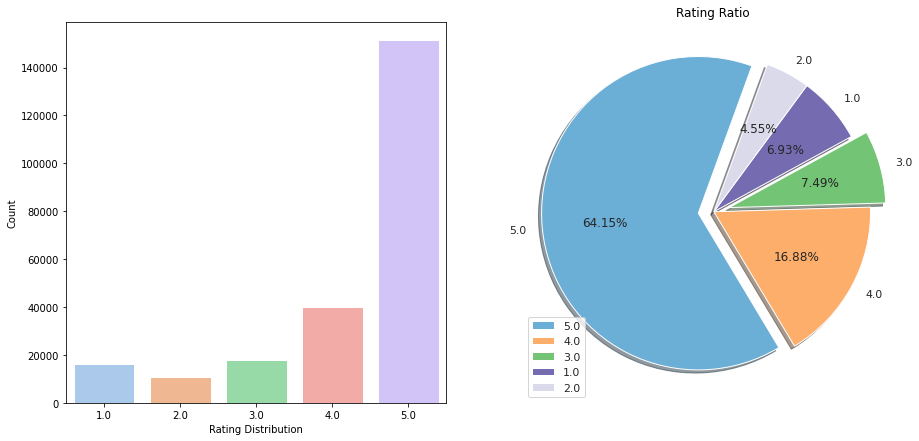

In [15]:
#Countplot of the ratings, maximum user-products have got rating as 5
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(rev1['overall'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
cmap = plt.get_cmap("tab20c")


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_cnt["Ratings"], explode=explode, labels=rating_cnt.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70,colors = cmap([1,6,9,12,15]))
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_cnt.Labels, loc=3)
plt.show()

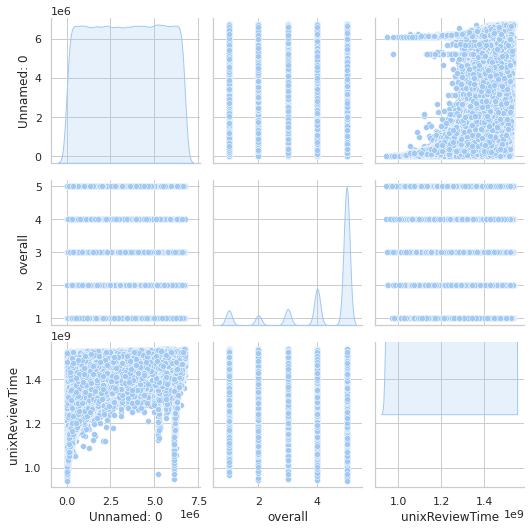

In [16]:
sns.pairplot(rev1, diag_kind= 'kde')

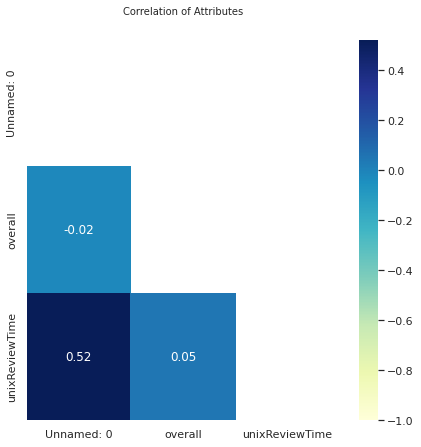

In [17]:
#correlations
mask = np.zeros_like(rev1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(7,7))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(rev1.corr(),vmin=-1, cmap='YlGnBu',annot=True,  mask=mask, fmt='.2f')

In [18]:
#Summary of the data
print("Data Summary....................................................................................")
print("\nTotal number of Ratings :",rev1.shape[0])
print("Total number of Users   :", len(np.unique(rev1.reviewerID)))
print("Total number of Products  :", len(np.unique(rev1.asin)))

Data Summary....................................................................................

Total number of Ratings : 235886
Total number of Users   : 190621
Total number of Products  : 73057


In [19]:
#Check and find the max ratings given by user for a particular item
max_rat = rev1.groupby(['reviewerID','asin'])['overall'].max().sort_values(ascending=False)
max_rat

reviewerID      asin      
AZZZ3LGTCGUZF   B00DRQWA0W    5.0
A2JBP38KY2RD7T  B00IPU5VA6    5.0
A2JC8RREUM7QRG  B012ASBZEO    5.0
A2JC8LWZKNV0D   B000ID7QNI    5.0
A2JC8KSUNQIBC6  B01ETUV4I8    5.0
                             ... 
A2FEG62RK2LYX8  B00LBPKSNW    1.0
AIJQ2PTTLYNWL   B00QRPPCMI    1.0
A1AWCFLECIYCUK  B000CRUZ7Y    1.0
A1QM3L4ZAWI59N  B00IR8R7WQ    1.0
A33P1Y85MALWRS  B007C1KKW8    1.0
Name: overall, Length: 235621, dtype: float64

In [20]:
#Check and find the min ratings given by user for a particular item
min_rat = rev1.groupby(['reviewerID','asin'])['overall'].min().sort_values(ascending=False)
min_rat

reviewerID      asin      
AZZZ3LGTCGUZF   B00DRQWA0W    5.0
A2JBO53J1DSEKT  B0009RKL6M    5.0
A2JC8LWZKNV0D   B000ID7QNI    5.0
A2JC8KSUNQIBC6  B01ETUV4I8    5.0
A2JC8BNOWADFJ   B006ROO1XA    5.0
                             ... 
A3J8QGARDPGMEK  B00WQYCKSS    1.0
A3D7CIQFT4MPRC  B001Q9A7RK    1.0
A3J8KLXSR1IKAX  B00BB0ZSIC    1.0
A2XVMEYID7X61C  B0065SMUOU    1.0
A2MPA1RFEZW5HB  B00AMC2J1Y    1.0
Name: overall, Length: 235621, dtype: float64

In [21]:
no_rat_each_person = rev1.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
ADLVFFE4VBT8      27
A680RUE1FDO8B     26
A3OA4DV4L81N1D    17
ARBKYIVNYWK3C     17
A23GFTVIETX7DS    16
A26877IWJGISYM    16
A31N0XY2UTB25C    15
A2LXX47A0KMJVX    15
AWPODHOB4GFWL     15
A12DQZKRKTNF5E    15
Name: overall, dtype: int64

In [22]:
no_rat_each_person.describe().astype(int)

count    190621
mean          1
std           0
min           1
25%           1
50%           1
75%           1
max          27
Name: overall, dtype: int64

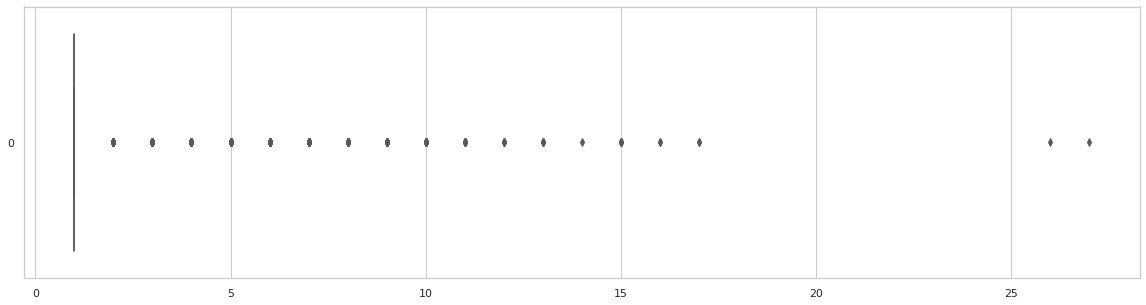

In [23]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_rat_each_person, orient='h', palette='Set2', dodge=False)

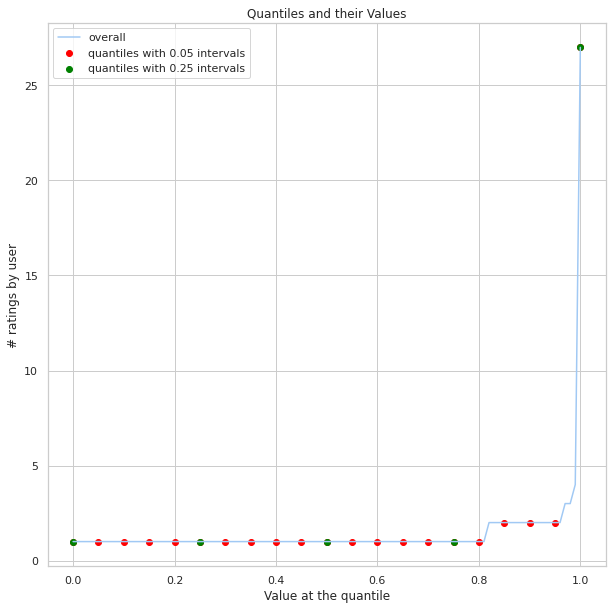

In [24]:
#We can see that all the ratings are clustered at the top end of the quantile

quantiles = no_rat_each_person.quantile(np.arange(0,1.01,0.01), interpolation='higher')
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='red', label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='green', label = "quantiles with 0.25 intervals")
plt.ylabel('# ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [26]:
new_df=deepcopy(rev1)

In [27]:
#total no. of rating for each person
new_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_rat_each_person.head(10)

reviewerID
ADLVFFE4VBT8      27
A680RUE1FDO8B     26
A3OA4DV4L81N1D    17
ARBKYIVNYWK3C     17
A23GFTVIETX7DS    16
A26877IWJGISYM    16
A31N0XY2UTB25C    15
A2LXX47A0KMJVX    15
AWPODHOB4GFWL     15
A12DQZKRKTNF5E    15
Name: overall, dtype: int64

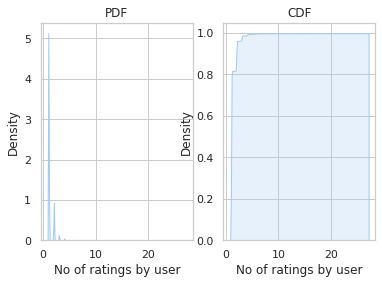

In [28]:
#PDF and CDF for the number of ratings per user
#PDF is left skewed as majority of the users have given very few ratings
ax1 = plt.subplot(121)
sns.kdeplot(no_rat_each_person, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_rat_each_person, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

<function matplotlib.pyplot.show>

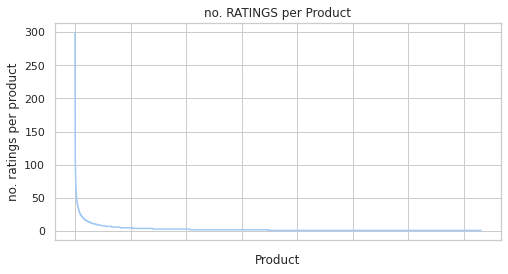

In [29]:
#plot of number of ratings per product
no_of_ratings_per_product = new_df.groupby(by='asin')['overall'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('no. RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('no. ratings per product')
ax.set_xticklabels([])

plt.show

In [30]:
quantiles = no_of_ratings_per_product.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [ ]:
ratings = deepcopy(df1)
ratings.drop(['reviewTime','image','style','vote','reviewText','reviewerName','verified','summary'],axis=1, inplace = True)
ratings.fillna(value = 0, inplace = True)
ratings.drop_duplicates
ratings

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
0,1425280,2.0,AMFPAS8VMIDGJ,B002B3YCQM,1422057600
1,4253927,4.0,ABID49T47BLBF,B00JXXXOS0,1512259200
2,3395176,5.0,A2IQGDEA5FONCT,B00CSQYVWM,1411516800
3,1421371,4.0,A29GIVFYIGNM79,B002AF5184,1354665600
4,2768360,5.0,A1MPC88C5RBO91,B008LTBM6S,1451952000
...,...,...,...,...,...
235881,2741767,5.0,A28FXEB3VIG8DU,B008DBI5RI,1360108800
235882,3967102,5.0,A1MGUMKNMC5DL5,B00HNDCWQM,1464998400
235883,1020058,5.0,A237SN14B2I5AX,B0014KQ4NM,1425513600
235884,3661069,3.0,A3VUQ1W0WOQAX4,B00EPCNB96,1446336000


In [ ]:
dataset=deepcopy(ratings)

In [ ]:
ratings = pd.DataFrame(ratings)

In [ ]:
ratings

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
0,1425280,2.0,AMFPAS8VMIDGJ,B002B3YCQM,1422057600
1,4253927,4.0,ABID49T47BLBF,B00JXXXOS0,1512259200
2,3395176,5.0,A2IQGDEA5FONCT,B00CSQYVWM,1411516800
3,1421371,4.0,A29GIVFYIGNM79,B002AF5184,1354665600
4,2768360,5.0,A1MPC88C5RBO91,B008LTBM6S,1451952000
...,...,...,...,...,...
235881,2741767,5.0,A28FXEB3VIG8DU,B008DBI5RI,1360108800
235882,3967102,5.0,A1MGUMKNMC5DL5,B00HNDCWQM,1464998400
235883,1020058,5.0,A237SN14B2I5AX,B0014KQ4NM,1425513600
235884,3661069,3.0,A3VUQ1W0WOQAX4,B00EPCNB96,1446336000


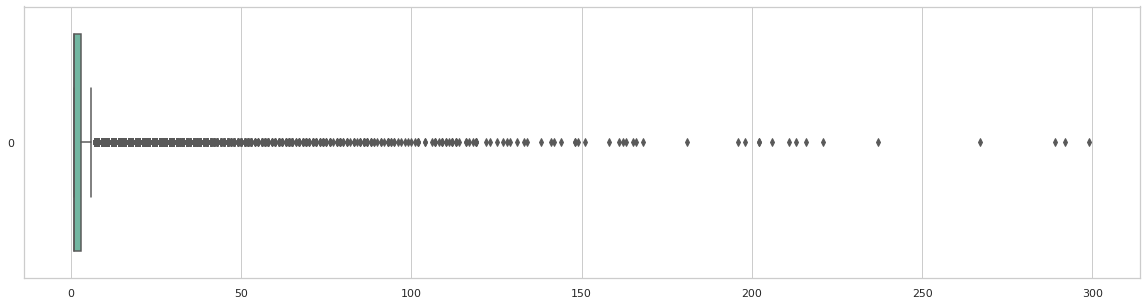

In [31]:
plt.figure(figsize=(20,5))
sns.boxplot(data=no_of_ratings_per_product, orient='h', palette='Set2', dodge=False)

In [32]:
copy_year=deepcopy(df1)
#Extract Year
def year_extract(reviewTime):
    year = reviewTime[-4:]
    return year

copy_year['Year'] = copy_year['reviewTime'].apply(year_extract)
l=copy_year['Year'].value_counts()
year_count=l.to_frame()
year_count.rename({'Year':'count'}, axis=1,inplace=True)
year_count.reset_index(level=0, inplace=True)
year_count.rename({'index':'year'}, axis=1,inplace=True)
year_count.head(5)

,year,count
0,2015,50243
1,2016,50214
2,2014,36296
3,2017,32187
4,2013,22252


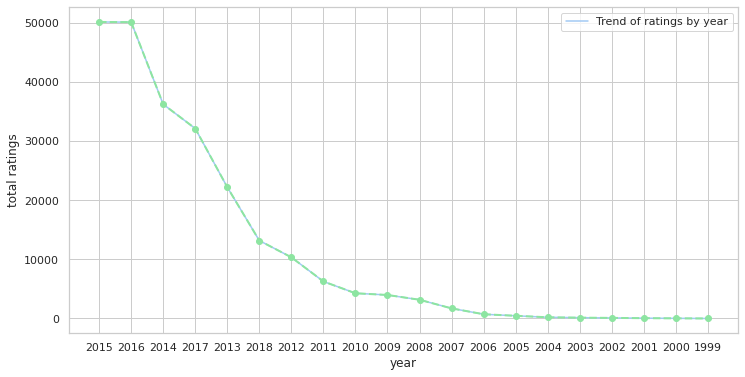

In [33]:
#year wise total number of sell
import matplotlib.pyplot as plt
  
x = year_count['year']
y = year_count['count']

  
# Plotting the Data
plt.figure(figsize=(12,6))
plt.plot(x, y, label='Trend of ratings by year')
  
plt.xlabel('year')
plt.ylabel('total ratings')
  
plt.plot(y, 'o:g', linestyle='--', linewidth='2')

  
plt.legend()

In [34]:
#Total no of rating for product
new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B0019HL8Q8    299
B0019EHU8G    292
B003L1ZYYW    289
B0015DYMVO    267
B00BWF5U0M    237
Name: overall, dtype: int64

In [35]:
#mean rating for a product
ratings_mean_count = pd.DataFrame(new_df.groupby('asin')['overall'].mean())
ratings_mean_count.head(5)

,overall
asin,
0380709473,4.00
0511189877,5.00
0545105668,4.50
0594296420,5.00
0594459451,4.75


In [36]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
ratings_mean_count.head(5)

,overall,rating_counts
asin,,
0380709473,4.00,1
0511189877,5.00,1
0545105668,4.50,2
0594296420,5.00,1
0594459451,4.75,4


In [37]:
#Total no of rating for product

new_df.groupby('asin')['overall'].count().sort_values(ascending=False).head()

asin
B0019HL8Q8    299
B0019EHU8G    292
B003L1ZYYW    289
B0015DYMVO    267
B00BWF5U0M    237
Name: overall, dtype: int64

In [38]:
ratings_mean_count['rating_counts'].max()

299

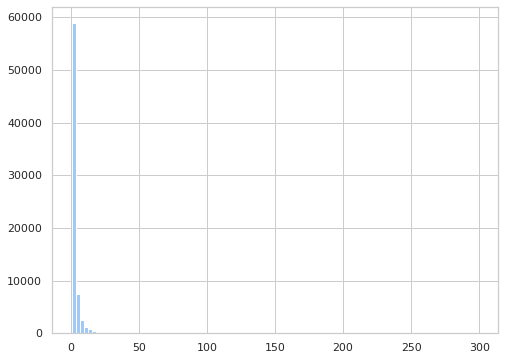

In [39]:
#Majority of the products have received 1 rating only and it is a right skewed distribution
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=100)

<Figure size 576x432 with 0 Axes>

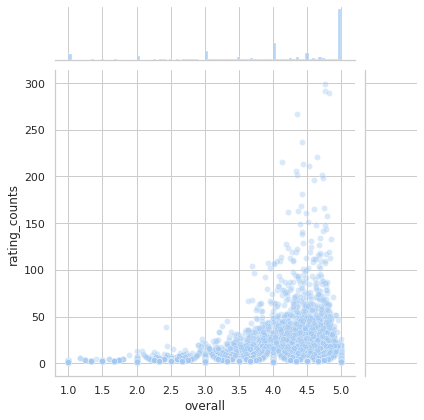

In [40]:
#From the joint plot below it seems that popular products (higher ratings) tend to be rated more frequently
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='overall', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [41]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('asin')['overall'].count())
ratings_mean_count.head()

,overall,rating_counts
asin,,
0380709473,4.00,1
0511189877,5.00,1
0545105668,4.50,2
0594296420,5.00,1
0594459451,4.75,4


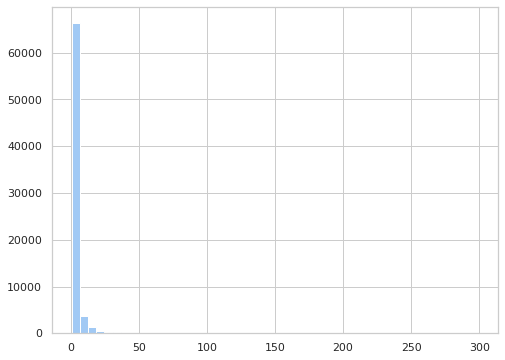

In [42]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

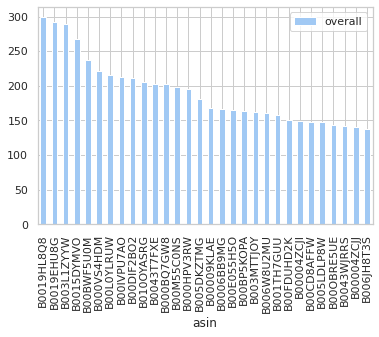

In [43]:
#Below is the bar graph showing product list of top 30 most popular products
popular_products = pd.DataFrame(new_df.groupby('asin')['overall'].count())
most_popular = popular_products.sort_values('overall', ascending=False)
most_popular.head(30).plot(kind = "bar")

In [45]:
ratings=deepcopy(new_df)
ratings

,Unnamed: 0,overall,reviewTime,reviewerID,asin,unixReviewTime
0,1425280,2.0,"01 24, 2015",AMFPAS8VMIDGJ,B002B3YCQM,1422057600
1,4253927,4.0,"12 3, 2017",ABID49T47BLBF,B00JXXXOS0,1512259200
2,3395176,5.0,"09 24, 2014",A2IQGDEA5FONCT,B00CSQYVWM,1411516800
3,1421371,4.0,"12 5, 2012",A29GIVFYIGNM79,B002AF5184,1354665600
4,2768360,5.0,"01 5, 2016",A1MPC88C5RBO91,B008LTBM6S,1451952000
...,...,...,...,...,...,...
235881,2741767,5.0,"02 6, 2013",A28FXEB3VIG8DU,B008DBI5RI,1360108800
235882,3967102,5.0,"06 4, 2016",A1MGUMKNMC5DL5,B00HNDCWQM,1464998400
235883,1020058,5.0,"03 5, 2015",A237SN14B2I5AX,B0014KQ4NM,1425513600
235884,3661069,3.0,"11 1, 2015",A3VUQ1W0WOQAX4,B00EPCNB96,1446336000


**MODEL BUILD**

#First Approach

##stratified train teast

In [ ]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [ ]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [ ]:
transformed_train = transformed_train.withColumnRenamed('overall','label')

In [ ]:
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

##ALS

In [ ]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [ ]:
prediction = model.transform(transformed_test)

In [ ]:
prediction.show(n=5, truncate = False)

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|A1ZM0YRS5S6Q17|B001W28L2Y|5.0      |148.0    |1194.0         |2.2066944 |
|A1VBHFHJVUUVXJ|B001W28L2Y|5.0      |148.0    |15750.0        |0.38332176|
|A1RARUIXA9W42 |B001W28L2Y|5.0      |148.0    |2875.0         |2.333861  |
|A3ADMT997MTZIM|B001W28L2Y|5.0      |148.0    |2119.0         |0.25526607|
|A1I3GXI6LSFS4O|B001W28L2Y|5.0      |148.0    |17815.0        |3.7194955 |
+--------------+----------+---------+---------+---------------+----------+
only showing top 5 rows



##rmse

In [ ]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 2.6754364989267003


#Second Approach

##model on over sampled data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split 

ratings=deepcopy(dataset)

#ratings,rat = train_test_split(ratings1, test_size=0.5, stratify=ratings['overall'])

In [ ]:
dataset

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
0,1425280,2.0,AMFPAS8VMIDGJ,B002B3YCQM,1422057600
1,4253927,4.0,ABID49T47BLBF,B00JXXXOS0,1512259200
2,3395176,5.0,A2IQGDEA5FONCT,B00CSQYVWM,1411516800
3,1421371,4.0,A29GIVFYIGNM79,B002AF5184,1354665600
4,2768360,5.0,A1MPC88C5RBO91,B008LTBM6S,1451952000
...,...,...,...,...,...
235881,2741767,5.0,A28FXEB3VIG8DU,B008DBI5RI,1360108800
235882,3967102,5.0,A1MGUMKNMC5DL5,B00HNDCWQM,1464998400
235883,1020058,5.0,A237SN14B2I5AX,B0014KQ4NM,1425513600
235884,3661069,3.0,A3VUQ1W0WOQAX4,B00EPCNB96,1446336000


In [ ]:
ratings

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
0,1425280,2.0,AMFPAS8VMIDGJ,B002B3YCQM,1422057600
1,4253927,4.0,ABID49T47BLBF,B00JXXXOS0,1512259200
2,3395176,5.0,A2IQGDEA5FONCT,B00CSQYVWM,1411516800
3,1421371,4.0,A29GIVFYIGNM79,B002AF5184,1354665600
4,2768360,5.0,A1MPC88C5RBO91,B008LTBM6S,1451952000
...,...,...,...,...,...
235881,2741767,5.0,A28FXEB3VIG8DU,B008DBI5RI,1360108800
235882,3967102,5.0,A1MGUMKNMC5DL5,B00HNDCWQM,1464998400
235883,1020058,5.0,A237SN14B2I5AX,B0014KQ4NM,1425513600
235884,3661069,3.0,A3VUQ1W0WOQAX4,B00EPCNB96,1446336000


In [ ]:
ratings = pd.DataFrame(ratings)
overall_group= ratings.groupby('overall')
rating_5= overall_group.get_group(5.0)
count_five = len(rating_5)
def oversampling(subset):
    count = len(subset)
    n=int(count_five/count)
    return (n)

In [ ]:
n1 = overall_group.get_group(1.0)
one_rating = overall_group.get_group(1.0)
rat_1= pd.concat([one_rating]*oversampling(one_rating),ignore_index=True)

n2 = overall_group.get_group(1.0)
two_rating = overall_group.get_group(2.0)
rat_2= pd.concat([two_rating]*oversampling(two_rating),ignore_index=True)

n3 = overall_group.get_group(1.0)
three_rating = overall_group.get_group(3.0)
rat_3= pd.concat([three_rating]*oversampling(three_rating),ignore_index=True)

n4 = overall_group.get_group(1.0)
four_rating = overall_group.get_group(4.0)
rat_4= pd.concat([four_rating]*oversampling(four_rating),ignore_index=True)

rat_5=rating_5

In [ ]:
oversampled_data= pd.concat([rat_5,rat_4,rat_3,rat_2,rat_1])
oversampled_data= oversampled_data.sample(frac=1,random_state=42)
oversampled_data

,Unnamed: 0,overall,reviewerID,asin,unixReviewTime
72720,3529590,5.0,A7OHA5SK5F0MD,B00DSUTX3O,1472256000
102301,4492216,1.0,A2CH61FZ4UCCG,B00M48154Q,1448755200
120483,2872009,2.0,A3PZ4QFHHU33B9,B0098O9TB0,1353888000
66976,5624443,4.0,AV1K506BMOSPC,B016C6Z1QS,1463270400
99012,1814200,5.0,AW8PGP1KBTDPW,B004B8GF7Y,1514505600
...,...,...,...,...,...
107852,5714937,4.0,A2JHO2LMM7E43O,B0187QWABA,1454976000
95085,2844689,3.0,AZN5T24NWUOM2,B0094R4Q6Y,1376438400
205584,219267,5.0,A96AU8QHOXW41,B0001FTVEA,1446422400
108790,2713396,1.0,AJRRIGZ7M4K3N,B0083XOZIE,1453161600


In [ ]:
ratings=deepcopy(oversampled_data)

Stratified train test split

In [ ]:
data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
pipeline = Pipeline(stages=indexer)
data = pipeline.fit(data).transform(data)

In [ ]:
transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
transformed_test = data.subtract(transformed_train)

In [ ]:
transformed_train = transformed_train.withColumnRenamed('overall','label')
transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

ALS

In [ ]:
als = ALS(maxIter = 20, regParam = 0.05 ,userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
model = als.fit(transformed_train)

In [ ]:
prediction = model.transform(transformed_test)

RMSE

In [ ]:
evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(prediction)
print("Root Mean Square Error(RMSE):", rmse)

Root Mean Square Error(RMSE): 3.0385104122500057


In [ ]:
ratings=deepcopy(new_df)

Automated optimization (avoid oversampling)

In [ ]:
# Tuning the parameters to find the minimum RMSE value by optimizing iterations and regular parameters
Score=[]
maxIter=[5,10,15]
regParam=[0.10,0.20,0.30,0.40]
rank=[5,10]
for j in maxIter:
    for i in regParam:
        for k in rank:
        
            als = ALS(rank=k, maxIter = j, regParam = i, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
            model = als.fit(transformed_train)
            prediction = model.transform(transformed_test)
            #prediction.show(n=5, truncate = False)

            evaluator = RegressionEvaluator(labelCol='truelabel',predictionCol='prediction', metricName='rmse')
            rmse = evaluator.evaluate(prediction)
            print("Root Mean Square Error(RMSE):", rmse)
            l=[]
            l.append(j)
            l.append(i)
            l.append(rmse)
            l.append(k)
            Score.append(l)

Root Mean Square Error(RMSE): 3.0230930560512514
Root Mean Square Error(RMSE): 2.9090700792942457
Root Mean Square Error(RMSE): 2.7957996530087845
Root Mean Square Error(RMSE): 2.831194694468269
Root Mean Square Error(RMSE): 2.733906883954285
Root Mean Square Error(RMSE): 2.7884974675213003
Root Mean Square Error(RMSE): 2.729394907450461
Root Mean Square Error(RMSE): 2.7799809264969984
Root Mean Square Error(RMSE): 2.743637990122706
Root Mean Square Error(RMSE): 2.7330139304216607
Root Mean Square Error(RMSE): 2.6110748845869636
Root Mean Square Error(RMSE): 2.655002238753126
Root Mean Square Error(RMSE): 2.592503661966842
Root Mean Square Error(RMSE): 2.634273783277959
Root Mean Square Error(RMSE): 2.605188052133095
Root Mean Square Error(RMSE): 2.6411409419420773
Root Mean Square Error(RMSE): 2.62631438882234
Root Mean Square Error(RMSE): 2.6420169605755777
Root Mean Square Error(RMSE): 2.5437374186184387
Root Mean Square Error(RMSE): 2.579403702501116
Root Mean Square Error(RMSE): 2

In [ ]:
score=[]
for i in range(len(Score)):
    score.append(Score[i][2])

min_Score=min(score)
for i in range(len(Score)):
    if Score[i][2]==min_Score:
        iter=Score[i][0]
        para=Score[i][1]
        rank=Score[i][3]
r=rank

User based recommendation

In [ ]:
def reco_user(id):
    temp_df = prediction.filter(prediction["reviewerID"] == id)
    temp_df = temp_df.sort("prediction", ascending=False)
    temp_df.show(n= 5, truncate = False)

In [ ]:
reco_user("A333636QFPT073")

+--------------+----------+---------+---------+---------------+----------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|
+--------------+----------+---------+---------+---------------+----------+
|A333636QFPT073|B00B3P15M8|5.0      |148.0    |15130.0        |2.1763065 |
+--------------+----------+---------+---------+---------------+----------+



In [ ]:
url2='/content/drive/MyDrive/dataset/meta_amazon_electronic_subset.csv'

In [ ]:
df_metadata = pd.read_csv(url2)

In [ ]:
df_metadata

,Unnamed: 0,asin,category,title
0,24,B002B3YCQM,"['Electronics', 'Computers & Accessories', 'Co...",Logitech M500 Corded Mouse &ndash; Wired USB M...
1,25,B00JXXXOS0,"['Electronics', 'Television & Video', 'DVD Pla...",Panasonic All Multi Region Code Zone Free PAL/...
2,35,B00CSQYVWM,"['Electronics', 'Camera & Photo', 'Underwater ...",GoPro HERO3 Skeleton Housing
3,44,B002AF5184,"['Electronics', 'Portable Audio & Video', 'MP3...",CrazyOnDigital Premium Black Leather Case Appl...
4,115,B008LTBM6S,"['Electronics', 'Computers & Accessories', 'Co...",Crucial 4GB Single DDR3/DDR3L 1600 MT/s (PC3-1...
...,...,...,...,...
72994,246840,B0048ABG6A,"['Electronics', 'Camera & Photo', 'Accessories...",Fotodiox Pro Lens Mount Adapter - Canon FD &am...
72995,246841,B004WI867K,"['Electronics', 'Computers & Accessories', 'La...",Cosmos &reg; Brown PU/synthetic/faux leather 1...
72996,246842,B01E5ITE2W,"['Electronics', 'Computers & Accessories', 'Co...",REDGO Video Audio VHS VCR USB Video Capture Ca...
72997,246843,B008XI59K2,"['Electronics', 'Computers & Accessories', 'La...",HP 2000 2000-2C29WM 2000-2B19WM 693711-001 677...


In [ ]:
prod = deepcopy(df_metadata)
prod = prod[['asin', 'title', 'category']]

In [ ]:
prod_title=prod[['asin', 'title']]

In [ ]:
prod

,asin,title,category
0,B002B3YCQM,Logitech M500 Corded Mouse &ndash; Wired USB M...,"['Electronics', 'Computers & Accessories', 'Co..."
1,B00JXXXOS0,Panasonic All Multi Region Code Zone Free PAL/...,"['Electronics', 'Television & Video', 'DVD Pla..."
2,B00CSQYVWM,GoPro HERO3 Skeleton Housing,"['Electronics', 'Camera & Photo', 'Underwater ..."
3,B002AF5184,CrazyOnDigital Premium Black Leather Case Appl...,"['Electronics', 'Portable Audio & Video', 'MP3..."
4,B008LTBM6S,Crucial 4GB Single DDR3/DDR3L 1600 MT/s (PC3-1...,"['Electronics', 'Computers & Accessories', 'Co..."
...,...,...,...
72994,B0048ABG6A,Fotodiox Pro Lens Mount Adapter - Canon FD &am...,"['Electronics', 'Camera & Photo', 'Accessories..."
72995,B004WI867K,Cosmos &reg; Brown PU/synthetic/faux leather 1...,"['Electronics', 'Computers & Accessories', 'La..."
72996,B01E5ITE2W,REDGO Video Audio VHS VCR USB Video Capture Ca...,"['Electronics', 'Computers & Accessories', 'Co..."
72997,B008XI59K2,HP 2000 2000-2C29WM 2000-2B19WM 693711-001 677...,"['Electronics', 'Computers & Accessories', 'La..."


Prediction

In [ ]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod.astype(str))

In [ ]:
jdf = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [ ]:
jdf.show(n=5,truncate=False)

+--------------+----------+---------+---------+---------------+----------+----------+----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|reviewerID    |asin      |truelabel|asinindex|reviewerIDindex|prediction|asin      |title                                                                                                                       |category                                                                                     |
+--------------+----------+---------+---------+---------------+----------+----------+----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|AAI87VMTG3EX7 |980035977X|3.0      |9210.0   |28878.0        |4.690188  |980035977X|

Meta data - Preprocessing

In [ ]:
from copy import deepcopy
meta_copy=deepcopy(df_metadata)

In [ ]:
meta_copy=meta_copy[['asin','category']]

In [ ]:
meta_list=meta_copy.values.tolist()
meta_list[:10]

[['B002B3YCQM',
  "['Electronics', 'Computers & Accessories', 'Computer Accessories & Peripherals', 'Keyboards, Mice & Accessories', 'Mice']"],
 ['B00JXXXOS0',
  "['Electronics', 'Television & Video', 'DVD Players & Recorders', 'DVD Players']"],
 ['B00CSQYVWM',
  "['Electronics', 'Camera & Photo', 'Underwater Photography', 'Housings']"],
 ['B002AF5184',
  "['Electronics', 'Portable Audio & Video', 'MP3 & MP4 Player Accessories', 'Cases']"],
 ['B008LTBM6S',
  "['Electronics', 'Computers & Accessories', 'Computer Components', 'Internal Components', 'Memory']"],
 ['B008422IL0', "['Electronics', 'Computers & Accessories', 'Data Storage']"],
 ['B00IU1R29I',
  "['Electronics', 'Computers & Accessories', 'Computer Accessories & Peripherals', 'Cables & Interconnects']"],
 ['B00016W6NC',
  "['Electronics', 'Computers &amp; Accessories', 'Computer Accessories &amp; Peripherals', 'Cables &amp; Interconnects', 'USB Cables']"],
 ['B002EL4MFC',
  "['Electronics', 'Computers & Accessories', 'Laptop A

In [ ]:
type(meta_list[1][1])

str

In [ ]:
meta_list[1][1]

"['Electronics', 'Television & Video', 'DVD Players & Recorders', 'DVD Players']"

In [ ]:
string=meta_list[1][1]
string = string.replace("[", "") 
string = string.replace("]", "") 
string = string.replace("\'", "") 
print(string)
li = list(string.split(","))
li

Electronics, Television & Video, DVD Players & Recorders, DVD Players


['Electronics',
 ' Television & Video',
 ' DVD Players & Recorders',
 ' DVD Players']

In [ ]:
category_list=[]
for i in range(len(meta_list)):
    s=[]
    string=meta_list[i][1]
    string = string.replace("[", "") 
    string = string.replace("]", "") 
    string = string.replace("\'", "") 

    li = list(string.split(","))

    s.append(meta_list[i][0]) 
    s.append(li[1])
    category_list.append(s)

In [ ]:
df_cat_asin=pd.DataFrame(category_list)

In [ ]:
df_cat_asin

,0,1
0,B002B3YCQM,Computers & Accessories
1,B00JXXXOS0,Television & Video
2,B00CSQYVWM,Camera & Photo
3,B002AF5184,Portable Audio & Video
4,B008LTBM6S,Computers & Accessories
...,...,...
72994,B0048ABG6A,Camera & Photo
72995,B004WI867K,Computers & Accessories
72996,B01E5ITE2W,Computers & Accessories
72997,B008XI59K2,Computers & Accessories


In [ ]:
df_cat_asin.rename({0:'asin',1:'category_type'}, axis=1,inplace=True)

In [ ]:
df_cat_asin.head(5)

,asin,category_type
0,B002B3YCQM,Computers & Accessories
1,B00JXXXOS0,Television & Video
2,B00CSQYVWM,Camera & Photo
3,B002AF5184,Portable Audio & Video
4,B008LTBM6S,Computers & Accessories


In [ ]:
df_inner = pd.merge(df1,df_cat_asin, on='asin', how='inner')

df_inner.head(3)

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,category_type
0,1425280,2.0,NaN,True,"01 24, 2015",AMFPAS8VMIDGJ,B002B3YCQM,{'Package Type:': ' Standard Packaging'},Crewtx,I've stopped counting the number of mice I've ...,I've stopped counting the number of mice I've ...,1422057600,NaN,Computers & Accessories
1,1424955,4.0,NaN,True,"03 26, 2016",A1UVU5YY6B6KQM,B002B3YCQM,{'Package Type:': ' Standard Packaging'},Oohla,this mouse worked for 1 month and 10 days. To...,Worked for under 2 months - Logitech was happy...,1458950400,NaN,Computers & Accessories
2,1425020,5.0,NaN,True,"11 28, 2015",A2G8K3GDE6R2Z5,B002B3YCQM,{'Package Type:': ' Standard Packaging'},Rick Strahl,I bought a tethered mouse after buying a new 4...,Love the Scroll Wheel on this Mouse,1448668800,NaN,Computers & Accessories


In [ ]:
df_inner['category_type'].value_counts()

 Computers & Accessories            104724
 Accessories & Supplies              37711
 Camera & Photo                      33043
 Headphones                          13239
 Portable Audio & Video              12323
 Television & Video                   6562
 Car & Vehicle Electronics            6556
 Home Audio                           4928
 GPS                                  3313
 Computers &amp; Accessories          2927
 Camera &amp; Photo                   2089
 Accessories &amp; Supplies           2085
 Security & Surveillance              1876
 eBook Readers & Accessories           967
 Wearable Technology                   914
 Video Projectors                      622
 Portable Audio &amp; Video            616
 Electronics Warranties                542
 Car &amp; Vehicle Electronics         333
 Television &amp; Video                128
 Security &amp; Surveillance            60
 eBook Readers &amp; Accessories        35
 Service Plans                          24
 Cell Phone

In [ ]:
prod1 = deepcopy(df_inner)
prod2 = prod1[['asin', 'category_type']]

##recommendation category wise

In [ ]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.getOrCreate()
sparkDF=spark.createDataFrame(prod2.astype(str))

In [ ]:
jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")

In [ ]:
ratings2 = deepcopy(df_inner)
ratings2.drop(['Unnamed: 0', 'verified', 'reviewTime', 
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],axis=1, inplace = True)
ratings2.fillna(value = 0, inplace = True)
ratings2.drop_duplicates
ratings2

,overall,reviewerID,asin,category_type
0,2.0,AMFPAS8VMIDGJ,B002B3YCQM,Computers & Accessories
1,4.0,A1UVU5YY6B6KQM,B002B3YCQM,Computers & Accessories
2,5.0,A2G8K3GDE6R2Z5,B002B3YCQM,Computers & Accessories
3,3.0,A1N499QUWCGE4N,B002B3YCQM,Computers & Accessories
4,4.0,A1OV75M25ENAND,B002B3YCQM,Computers & Accessories
...,...,...,...,...
235615,5.0,ADDOTT8YOT0NS,B0048ABG6A,Camera & Photo
235616,5.0,AKH6N84CBOBJ6,B004WI867K,Computers & Accessories
235617,5.0,A2J0CYSHN37GA1,B01E5ITE2W,Computers & Accessories
235618,5.0,AVW3SN671V6Q,B008XI59K2,Computers & Accessories


In [ ]:
l=df_inner['category_type'].unique()
#l

In [ ]:
ratings2.loc[ratings2['category_type']==' Computers & Accessories']

,overall,reviewerID,asin,category_type
0,2.0,AMFPAS8VMIDGJ,B002B3YCQM,Computers & Accessories
1,4.0,A1UVU5YY6B6KQM,B002B3YCQM,Computers & Accessories
2,5.0,A2G8K3GDE6R2Z5,B002B3YCQM,Computers & Accessories
3,3.0,A1N499QUWCGE4N,B002B3YCQM,Computers & Accessories
4,4.0,A1OV75M25ENAND,B002B3YCQM,Computers & Accessories
...,...,...,...,...
235609,4.0,A16Q4CLQP3943B,B00OKULAQY,Computers & Accessories
235611,5.0,A2IYVGCV556T7K,B01EJ7PCY8,Computers & Accessories
235616,5.0,AKH6N84CBOBJ6,B004WI867K,Computers & Accessories
235617,5.0,A2J0CYSHN37GA1,B01E5ITE2W,Computers & Accessories


In [ ]:
def preprocessed(data,r,iter,para):
    #preprocessed = ratings2.values.tolist()
    ##temp_data=data.loc[data['category_type']==cat]
    ##dff=pd.DataFrame(temp_data)
    ##temp_data_f=dff.drop(['category_type'],axis=1)
    
    data = spark.createDataFrame(ratings[['reviewerID', 'asin', 'overall']])
    indexer = [StringIndexer(inputCol = column, outputCol = column+"index") for column in ['asin','reviewerID']]
    pipeline = Pipeline(stages=indexer)
    data = pipeline.fit(data).transform(data)

    transformed_train = data.sampleBy("overall", fractions={1: 0.7, 2: 0.7, 3: 0.7,4: 0.7,5: 0.7}, seed=10)
    transformed_test = data.subtract(transformed_train)

    transformed_train = transformed_train.withColumnRenamed('overall','label')
    transformed_test = transformed_test.withColumnRenamed('overall','truelabel')

    als = ALS(rank=r, maxIter = iter, regParam = para, userCol = 'reviewerIDindex', itemCol = 'asinindex', ratingCol = 'label', coldStartStrategy='drop', nonnegative=True)
    model = als.fit(transformed_train)
    prediction = model.transform(transformed_test)
    jdf2 = prediction.join(sparkDF,prediction["asin"] ==  sparkDF["asin"],"inner")
    jdf2=jdf2.dropDuplicates(['reviewerID','asin','truelabel','asinindex','reviewerIDindex','prediction','asin','category_type'])
    #jdf2.show(n=5,truncate=False)
    return(jdf2)

In [ ]:
def reco_user_category(user_id,cat,data,title,r,iter,para):
    temp_data=data.loc[data['category_type']==cat]
    dff=pd.DataFrame(temp_data)
    temp_data_f=dff.drop(['category_type'],axis=1)

    prediction=preprocessed(temp_data,r,iter,para)
    temp_df = prediction.filter(prediction["reviewerID"] == user_id)
    temp_df = temp_df.sort("prediction", ascending=False)
    pandas_df = temp_df.select("*").toPandas()
    #print(pandas_df)
    if len(pandas_df)<5:
        #popularity based
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        #print(ratings)
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        #print(ratings)
        #print(ratings.columns)
        #print(type(ratings))
        
        recommendation=ratings[:5]
       # print(recommendation)
       # ratings.rename(columns={"overall": "Rating_Median"}, inplace=True)  
        l1=pandas_df.loc[:,'asin']
        #print(l1)
        l2=recommendation.loc[:,'asin']
        #print(l2)
        reco=l1.values.tolist()
        for i in l2.values.tolist():
            if i not in l1.values.tolist():
                reco.append(i)
            if len(reco)==5:
                break

    else:
       reco=pandas_df['asin'][:5]
    df = pd.DataFrame(reco)
    df.rename(columns={0: "asin"},inplace=True)
    recommend = pd.merge(df,title, on='asin', how='inner').drop_duplicates( keep='last')

    return(recommend)

In [ ]:
reco_user_category('AMFPAS8VMIDGJ',' Computers & Accessories',ratings2,prod_title,r,iter,para)

,asin,title
0,B01HJCN1EI,"Android charger cable 10 ft, Extra long Nylon ..."
1,B00BWBEL1U,Acer V226WL bd 22-Inch Screen LED-Lit Monitor
2,B00BUZ0K68,Tera Grand - Premium USB 2.0 to RS232 Serial D...
3,B00BV31QU8,"ROSEWILL ATX Mid Tower Gaming Computer Case, G..."
4,B00BV9KAOK,Lenovo Flex 14 Flex 14d Flex 15 Flex 15D Y40-7...


In [ ]:
list_category=df_inner['category_type'].unique()
for i in list_category[:4]:
    print(i)
    print(reco_user_category('AMFPAS8VMIDGJ',i,ratings2,prod_title,r,iter,para))

 Computers & Accessories
         asin                                              title
0  B01HJCN1EI  Android charger cable 10 ft, Extra long Nylon ...
1  B00BWBEL1U      Acer V226WL bd 22-Inch Screen LED-Lit Monitor
2  B00BUZ0K68  Tera Grand - Premium USB 2.0 to RS232 Serial D...
3  B00BV31QU8  ROSEWILL ATX Mid Tower Gaming Computer Case, G...
4  B00BV9KAOK  Lenovo Flex 14 Flex 14d Flex 15 Flex 15D Y40-7...
 Television & Video
         asin                                              title
0  B01HB3YWLG  Happycamping TV Antenna 50 Miles Range Amplifi...
1  B000X3NROK  Sony Bravia M-Series KDL-37M3000 37-Inch 720p ...
2  B000XG532Q        Toshiba REGZA 42HL67U 42-Inch 720p LCD HDTV
3  B00A0EUA2Y  RCA LED55C55R120Q 55-Inch 1080p 120Hz LED HDTV...
4  B00A7BGMTU  oCOSMO CE3200V 32-Inch 720p 60Hz LED  TV-DVD C...
 Camera & Photo
         asin                                              title
0  B01HITUTV0  Foto&amp;Tech Safety Camera Strap Tether Leash...
1  B0078OVG0O                

##Cross category

In [ ]:
df_item_info = pd.merge(prod_title,df_cat_asin, on='asin', how='inner')

df_item_info.head(3)

In [ ]:
def popular(data):
    l=data['category_type'].unique()
    list_rec=[]
    for cat in l:
        temp_data=data.loc[data['category_type']==cat]
        dff=pd.DataFrame(temp_data)
        temp_data_f=dff.drop(['category_type'],axis=1)
        ratings = pd.DataFrame(temp_data_f.groupby('asin')['overall'].median().sort_values(ascending=False).head())
        ratings=pd.DataFrame(ratings)
        ratings.reset_index(inplace=True)
        
        recommendation=ratings[:5]
        l1=recommendation.loc[:,'asin']
        reco=l1.values.tolist()
        for i in reco:
            list_rec.append(i)
    return(list_rec)

In [ ]:
def reco_user_cross_category(user_id,data,item,r,iter,para):
    

    user_list=data['reviewerID']
    user=[]
    for i in user_list:
        user.append(i)

    if user_id in user:
    
        user_subset=data_copy.groupby('reviewerID')
        user_data=user_subset.get_group(user_id)
        user_category=user_data['category_type']
        cat_list=[]
        for i in user_category:
            if i not in cat_list:
                 cat_list.append(i)
        print('recommended categories for previous user',cat_list)
        for i in cat_list:
            print(i)
            print(reco_user_category(user_id,i,ratings2,prod_title,r,iter,para))

    else:
    
        top_rec=popular(data)
        print('recommendation for new user',top_rec)
    


In [ ]:
type(prod_title)

pandas.core.frame.DataFrame

In [ ]:
prod_title_list=prod_title.values.tolist()
prod_df=pd.DataFrame(prod_title_list)
print(type(prod_df),prod_df)

<class 'pandas.core.frame.DataFrame'>                 0                                                  1
0      B002B3YCQM  Logitech M500 Corded Mouse &ndash; Wired USB M...
1      B00JXXXOS0  Panasonic All Multi Region Code Zone Free PAL/...
2      B00CSQYVWM                       GoPro HERO3 Skeleton Housing
3      B002AF5184  CrazyOnDigital Premium Black Leather Case Appl...
4      B008LTBM6S  Crucial 4GB Single DDR3/DDR3L 1600 MT/s (PC3-1...
...           ...                                                ...
72994  B0048ABG6A  Fotodiox Pro Lens Mount Adapter - Canon FD &am...
72995  B004WI867K  Cosmos &reg; Brown PU/synthetic/faux leather 1...
72996  B01E5ITE2W  REDGO Video Audio VHS VCR USB Video Capture Ca...
72997  B008XI59K2  HP 2000 2000-2C29WM 2000-2B19WM 693711-001 677...
72998  B00HNDCWQM  Fosmon 3 RCA Male to 3 RCA Male Stereo Audio C...

[72999 rows x 2 columns]


In [ ]:
l=reco_user_cross_category('A24QYDVR8BKT5',ratings2,prod_title,r,iter,para)

recommended categories for previous user [' Portable Audio & Video']
 Portable Audio & Video
         asin                                              title
0  B00B8PRRTI  Eton Rugged Rukus Solar-powered, Bluetooth, sm...
1  B00CBD65Z8  TOMTOP Mini Digital Portable Music MP3/4 Playe...
2  B009WTYIKS  For Apple iPod Touch 5 Armor 3 in 1 w/Stand Bl...
3  B009WGCGUA  iPod Touch 6 Case, 3-in-1 Duo Armor Case and H...
4  B009W5O2U8  Scosche boomSTREAM mini Portable Bluetooth Wir...


In [ ]:
l=reco_user_cross_category('monalisa',ratings2,prod_title,r,iter,para)

recommendation for new user ['B01HJCN1EI', 'B00BWBEL1U', 'B00BUZ0K68', 'B00BV31QU8', 'B00BV9KAOK', 'B01HB3YWLG', 'B000X3NROK', 'B000XG532Q', 'B00A0EUA2Y', 'B00A7BGMTU', 'B01HITUTV0', 'B0078OVG0O', 'B0078K17WK', 'B0078K16IK', 'B0078J2HS4', 'B00B8PRRTI', 'B00CBD65Z8', 'B009WTYIKS', 'B009WGCGUA', 'B009W5O2U8', 'B01GXJTDEU', 'B000097O5F', 'B00092DAFG', 'B0009FUX94', 'B0009HAI4W', 'B01HJDR9DQ', 'B00HFYGQHU', 'B007AUW3F8', 'B007B4ZDUA', 'B007B5Q25E', 'B00STP874O', 'B001NTFAOS', 'B001NTBVPA', 'B00U109CIA', 'B00U57WIYO', 'B00BLQ2T9M', 'B007P2NKNU', 'B007AQ2W2Q', 'B007AQ2YMO', 'B007BFZ4NU', 'B00CWEJ5NA', 'B00GYCWY70', 'B007KOS31W', 'B0043BVJ2U', 'B00EZB26I4', 'B00GSJROBA', 'B00BFF92XK', 'B00BPCQ6H8', 'B00BMFYYO0', 'B000ZZINTK', 'B00006JPV6', 'B00H3TJ3P4', 'B00FTH6WNS', 'B000N20668', 'B00G2QCJW8', 'B001JM55CQ', 'B000COVZD0', 'B00069QNGA', 'B0006BKG9I', 'B0006GR8CQ', 'B01GCP0QIM', 'B0000C4G8B', 'B0000C73CQ', 'B0000DC0T3', 'B0000DIVAQ', 'B002I007IA', 'B001N85Z12', 'B001N82JSY', 'B003V5B76C', 'B003